# Анализ динамики душевого ВВП


## Общий подход

За основу возьмем базу данных МВФ от апреля 2019 года с 1980г (начала публикации) до 2018г включительно.
Для устранения влияния уровня цен будем использовать ВВП в постоянных ценах на душу населения по паритету покупательной способности (Gross domestic product per capita, constant prices - Purchasing power parity; 2011 international dollar).

Согласно базовой экономической теории темпы должны быть больше у стран с меньшим душевым ВВП. Также на темпы роста влияет общемировая экономическая конъюнктура. Для учета этих факторов перелагается построить зависимость темпов роста от года и уровня душевого ВВП для 25%, 50% и 75% процентили темпов роста. На основе этого грубо можно расставить оценки 2, 3, 4 и 5 по темпам роста для отдельных стран в каждом году.

Для построения зависимости будет использоваться один из самых мощных методов машинного обучения градиентный бустинг в реализации catboost.

## Импорт библиотек для проведения анализа

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import catboost

# Фиксируем начальное занчение генератора случайных чисел для воспроизводимости
SEED = 704
%matplotlib inline

## Загрузка данных и отбражение последних значений

In [2]:
GDP = pd.read_csv(
    "raw/WEOApr2019.csv", 
    sep="\t", 
    index_col=[0, 1, 2, 3], 
    encoding="windows-1250", 
    thousands=",",
    skipfooter=1,
    usecols=lambda x: x != "Estimates Start After",
    engine="python"
).T
GDP.tail()

Country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,Austria,...,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
Subject Descriptor,"Gross domestic product per capita, constant prices","Gross domestic product per capita, constant prices","Gross domestic product per capita, constant prices","Gross domestic product per capita, constant prices","Gross domestic product per capita, constant prices","Gross domestic product per capita, constant prices","Gross domestic product per capita, constant prices","Gross domestic product per capita, constant prices","Gross domestic product per capita, constant prices","Gross domestic product per capita, constant prices",...,"Gross domestic product per capita, constant prices","Gross domestic product per capita, constant prices","Gross domestic product per capita, constant prices","Gross domestic product per capita, constant prices","Gross domestic product per capita, constant prices","Gross domestic product per capita, constant prices","Gross domestic product per capita, constant prices","Gross domestic product per capita, constant prices","Gross domestic product per capita, constant prices","Gross domestic product per capita, constant prices"
Units,Purchasing power parity; 2011 international dollar,Purchasing power parity; 2011 international dollar,Purchasing power parity; 2011 international dollar,Purchasing power parity; 2011 international dollar,Purchasing power parity; 2011 international dollar,Purchasing power parity; 2011 international dollar,Purchasing power parity; 2011 international dollar,Purchasing power parity; 2011 international dollar,Purchasing power parity; 2011 international dollar,Purchasing power parity; 2011 international dollar,...,Purchasing power parity; 2011 international dollar,Purchasing power parity; 2011 international dollar,Purchasing power parity; 2011 international dollar,Purchasing power parity; 2011 international dollar,Purchasing power parity; 2011 international dollar,Purchasing power parity; 2011 international dollar,Purchasing power parity; 2011 international dollar,Purchasing power parity; 2011 international dollar,Purchasing power parity; 2011 international dollar,Purchasing power parity; 2011 international dollar
Scale,Units,Units,Units,Units,Units,Units,Units,Units,Units,Units,...,Units,Units,Units,Units,Units,Units,Units,Units,Units,Units
2014,1819.260,10328.955,13490.897,7086.821,21811.269,18935.003,7755.846,34858.961,44713.655,44331.638,...,38863.071,52042.716,19631.542,5428.624,2473.781,17039.990,5370.260,3600.338,3609.302,2471.364
2015,1783.941,10587.715,13692.846,6944.557,22447.906,19243.580,7994.229,34281.483,45156.350,44393.629,...,39462.618,53156.548,19628.377,5755.966,2422.100,15763.972,5667.409,2912.482,3602.189,2452.062
2016,1774.189,10959.542,13828.922,6563.180,23281.034,18645.092,8014.463,34033.785,45640.280,44727.456,...,39839.527,53606.398,19884.535,6164.876,2470.670,13037.879,5955.909,2442.485,3624.618,2407.849
2017,1776.667,11380.817,13725.076,6351.606,23868.651,18933.296,8613.141,34663.559,46000.572,45478.962,...,40324.983,54440.896,20336.936,6597.660,2521.689,11075.011,6296.936,2232.600,3634.446,2457.418
2018,1792.807,11861.930,13724.501,6057.241,24872.466,18255.340,9045.501,34950.576,46554.634,46344.826,...,40626.720,55649.950,20688.323,6813.797,2543.870,9487.127,6676.087,2113.119,3647.591,2477.915


## Уберем лишнии заголовки для лучшей читаемости

Данные по 193 странам - по некоторым статистика не полная

In [3]:
GDP.columns = GDP.columns.droplevel([1, 2, 3])
GDP.index = GDP.index.map(pd.to_numeric)
GDP

Country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Aruba,Australia,Austria,...,United Kingdom,United States,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
1980,NaN,4832.599,10804.443,5276.667,9082.002,14710.090,NaN,NaN,24402.805,26129.829,...,20547.116,29135.978,9872.063,NaN,2216.690,18247.376,1013.847,NaN,3158.251,NaN
1981,NaN,5006.762,10793.204,4911.744,9502.954,13621.501,NaN,NaN,25008.792,26051.388,...,20378.545,29577.300,9990.981,NaN,2235.910,17477.043,1050.709,NaN,3260.415,NaN
1982,NaN,5044.226,11126.685,4785.152,9605.137,12973.733,NaN,NaN,24615.755,26515.100,...,20812.967,28767.383,8999.468,NaN,2206.032,17421.580,1114.383,NaN,3066.992,NaN
1983,NaN,4992.692,11354.824,4858.921,10268.087,13270.023,NaN,NaN,24191.265,27339.191,...,21682.033,29813.851,8648.517,NaN,2218.322,15273.409,1171.207,NaN,2939.647,NaN
1984,NaN,4986.521,11617.525,5017.799,11497.089,13308.665,NaN,NaN,25408.429,27426.943,...,22139.024,31692.731,8499.678,NaN,2355.976,15632.387,1245.713,NaN,2802.943,NaN
1985,NaN,4811.770,11701.673,4608.791,12586.548,12175.451,NaN,NaN,26418.521,28023.308,...,23008.739,32722.011,8570.610,NaN,2291.422,15340.105,1290.596,NaN,2754.217,NaN
1986,NaN,4983.941,11370.948,4610.711,14280.633,12879.954,NaN,NaN,26665.802,28649.251,...,23676.909,33548.731,9277.242,NaN,2222.174,16077.815,1307.428,NaN,2719.391,NaN
1987,NaN,4846.314,11001.829,4679.371,15495.797,13056.981,NaN,NaN,27534.047,29091.877,...,24879.286,34400.814,9957.252,NaN,2127.251,16437.154,1311.054,NaN,2679.656,NaN
1988,NaN,4689.155,10479.311,4835.200,16550.257,12646.924,NaN,NaN,28202.015,29334.123,...,26260.120,35513.421,10043.865,NaN,2033.514,17079.568,1351.878,NaN,2842.319,NaN
1989,NaN,5012.146,10715.540,4708.088,17580.036,11616.809,NaN,NaN,29071.601,30402.132,...,26858.701,36472.583,10098.636,NaN,2050.551,14351.534,1428.663,NaN,2656.886,NaN


## Расчитаем темпы роста и построим графики для избранных стран

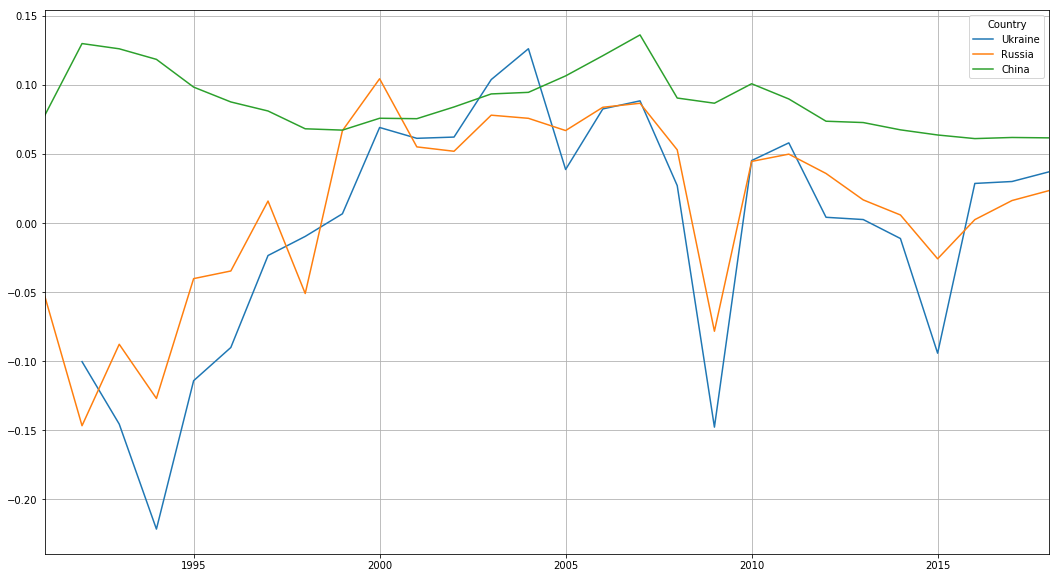

In [4]:
GDP_growth = GDP.pct_change()
GDP_growth.loc[1991:][["Ukraine", "Russia", "China"]].plot(figsize=(18, 10), grid=True)

## Преобразуем данные для построения модели

Всего есть около 6000 значений для построения зависимости темпов роста от душевого ВВП

In [5]:
# Объединим данные по темпам роста и душевому ВВП (со сдвигом на 1)
GDP = GDP.shift(1)
data = pd.concat([GDP.unstack(), GDP_growth.unstack()], axis=1)
# Удалим пропуски в данных
data.dropna(inplace=True)
# Перенесем год из названия строк в сами данные и установим название столбцов
data.reset_index(1, inplace=True)
data.columns = ["year", "GDP", "GDP_growth"]
print(data.head())
data.info()

             year       GDP  GDP_growth
Country                                
Afghanistan  2003  1026.919    0.043978
Afghanistan  2004  1072.081   -0.031121
Afghanistan  2005  1038.717    0.080416
Afghanistan  2006  1122.246    0.021940
Afghanistan  2007  1146.868    0.091432
<class 'pandas.core.frame.DataFrame'>
Index: 6562 entries, Afghanistan to Zimbabwe
Data columns (total 3 columns):
year          6562 non-null int64
GDP           6562 non-null float64
GDP_growth    6562 non-null float64
dtypes: float64(2), int64(1)
memory usage: 205.1+ KB


## Строим зависимость

In [6]:
x = data[["year", "GDP"]]
y = data.GDP_growth
params = dict(
    random_state=SEED,
    od_type="Iter",
    verbose=False,
    allow_writing_files=False,
)
clf25 = catboost.CatBoostRegressor(loss_function="Quantile:alpha=0.25", verbose=200)
clf50 = catboost.CatBoostRegressor(loss_function="Quantile:alpha=0.50", verbose=200)
clf75 = catboost.CatBoostRegressor(loss_function="Quantile:alpha=0.75", verbose=200)

result = []
for name, clf in [("25%", clf25), ("50%", clf50), ("75%", clf75)]:
    clf.fit(x, y)
    result.append(pd.DataFrame(clf.predict(x), index=x.index, columns=[name]))
    print()
result = pd.concat([x.year] + result + [y], axis=1)

0:	learn: 0.0154209	total: 58.5ms	remaining: 58.5s
200:	learn: 0.0136481	total: 721ms	remaining: 2.87s
400:	learn: 0.0133320	total: 1.45s	remaining: 2.17s
600:	learn: 0.0130925	total: 2.45s	remaining: 1.63s
800:	learn: 0.0129286	total: 3.22s	remaining: 801ms
999:	learn: 0.0127705	total: 3.98s	remaining: 0us

0:	learn: 0.0188232	total: 4.71ms	remaining: 4.7s
200:	learn: 0.0159507	total: 697ms	remaining: 2.77s
400:	learn: 0.0155830	total: 1.36s	remaining: 2.02s
600:	learn: 0.0153413	total: 2.08s	remaining: 1.38s
800:	learn: 0.0151657	total: 2.76s	remaining: 687ms
999:	learn: 0.0150273	total: 3.49s	remaining: 0us

0:	learn: 0.0190254	total: 3.84ms	remaining: 3.83s
200:	learn: 0.0132519	total: 668ms	remaining: 2.65s
400:	learn: 0.0129882	total: 1.3s	remaining: 1.94s
600:	learn: 0.0127874	total: 2.03s	remaining: 1.35s
800:	learn: 0.0125945	total: 2.92s	remaining: 725ms
999:	learn: 0.0124629	total: 3.62s	remaining: 0us



## Визуализация для избранных стран

In [7]:
def contry_summry(country):
    print(f"{country.upper()}")
    df = result.loc[country].set_index("year")
    print(f"Пемп роста душевого ВВП в 2018 году - {df.loc[2018, 'GDP_growth']:.1%}")
    print()
    print(f"Нормальный темп роста душевого ВВП - {df.loc[2018, '50%']:.1%}")
    print(f"25% аналогичных стран растет быстрее - {df.loc[2018, '75%']:.1%}")
    print(f"25% аналогичных стран растет медленнее - {df.loc[2018, '25%']:.1%}")
    df.plot(figsize=(18, 10), style=[":", "--", ":", "-"], color=["gray", "gray", "gray", "red"], grid=True)

RUSSIA
Пемп роста душевого ВВП в 2018 году - 2.4%

Нормальный темп роста душевого ВВП - 2.8%
25% аналогичных стран растет быстрее - 3.7%
25% аналогичных стран растет медленнее - 2.8%


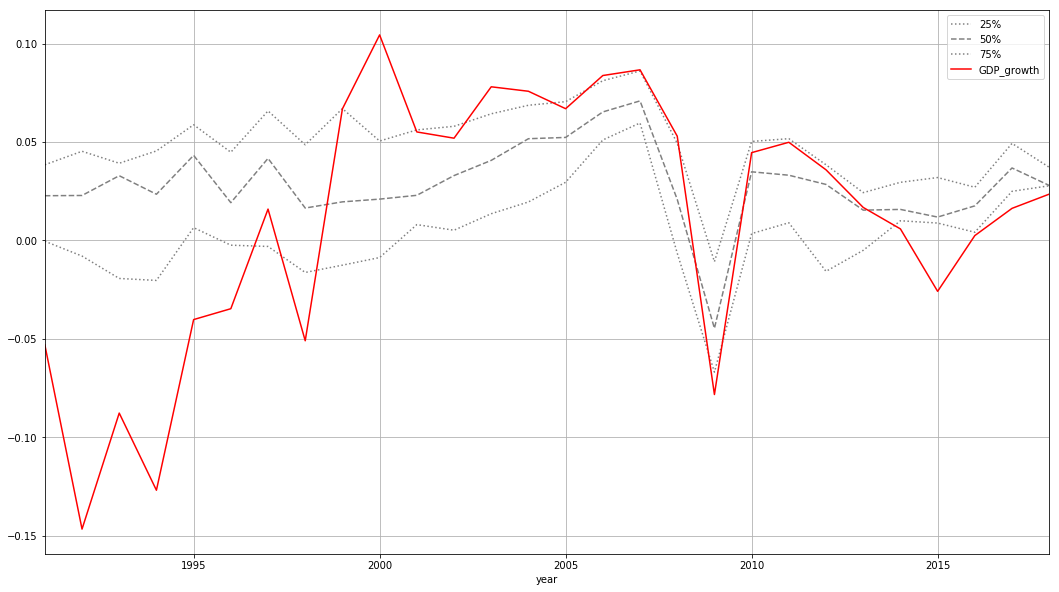

In [8]:
contry_summry("Russia")

UKRAINE
Пемп роста душевого ВВП в 2018 году - 3.7%

Нормальный темп роста душевого ВВП - 3.6%
25% аналогичных стран растет быстрее - 5.5%
25% аналогичных стран растет медленнее - 1.4%


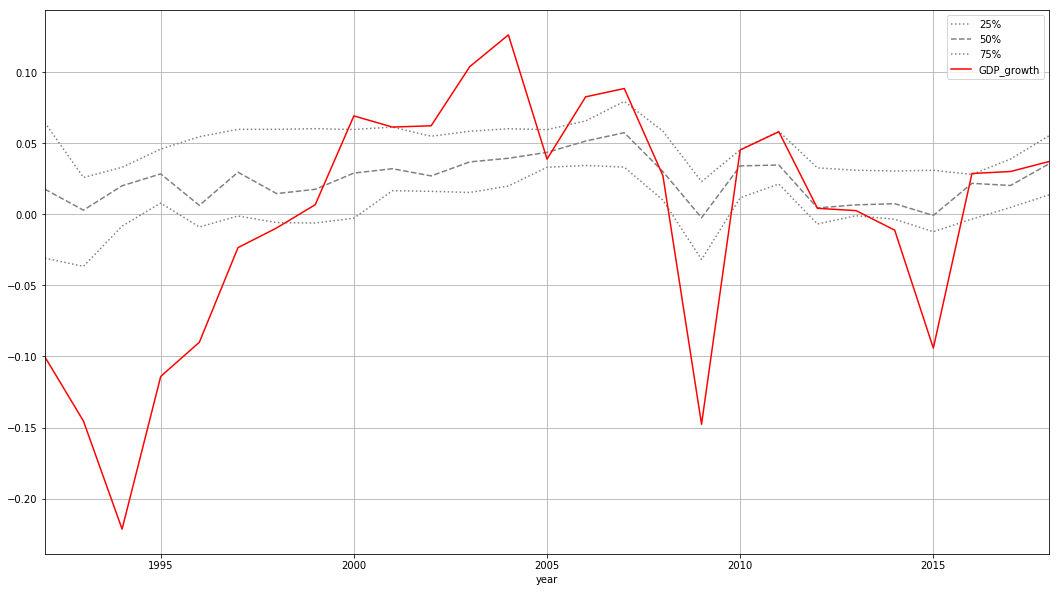

In [9]:
contry_summry("Ukraine")

CHINA
Пемп роста душевого ВВП в 2018 году - 6.2%

Нормальный темп роста душевого ВВП - 3.0%
25% аналогичных стран растет быстрее - 5.0%
25% аналогичных стран растет медленнее - 1.7%


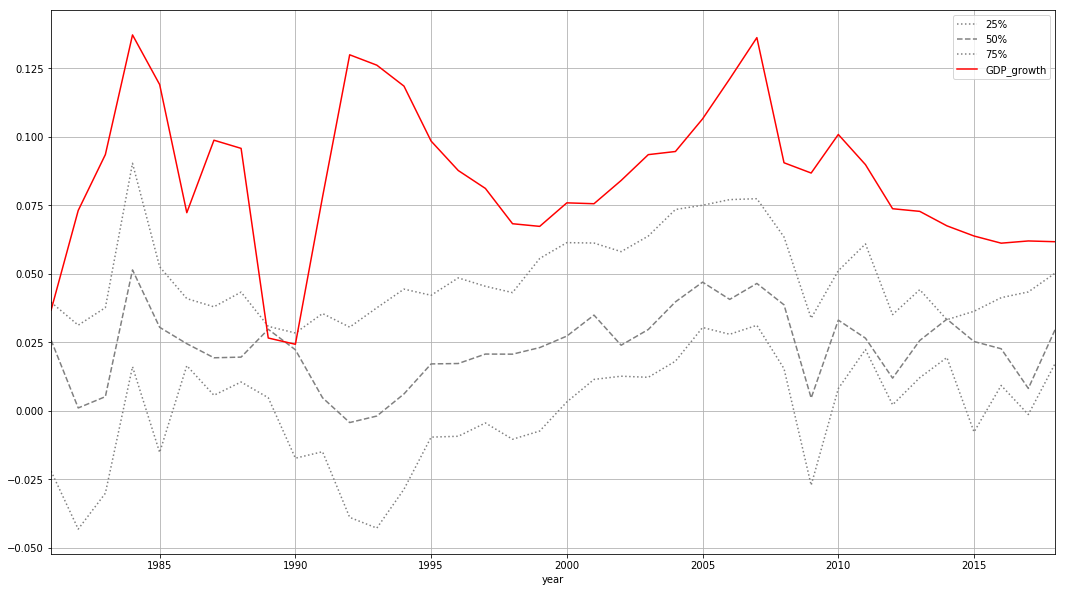

In [10]:
contry_summry("China")